<a href="https://colab.research.google.com/github/akibkhan1/skin-lesion-classification/blob/main/Skin_Lesion_Preprocessing_and_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from shutil import copyfile, move

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1931681408095443731, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 293433443771192135
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

###Download Zip

In [3]:
!gdown --id "1YkYnPgkRLDIQAbrnP81z8S1rDtEBEguj"

Downloading...
From: https://drive.google.com/uc?id=1YkYnPgkRLDIQAbrnP81z8S1rDtEBEguj
To: /content/lesion-full.zip
3.60GB [00:58, 61.4MB/s]


In [4]:
local_zip = '/content/lesion-full.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

###Check Directory Length

In [5]:
print(len(os.listdir('/content/lesion-full')))

2298


###Creating File Paths from CSV

In [6]:
!gdown --id '1XrieFe-vJFfcg1-NGUrtvz63QTiukiTi'

Downloading...
From: https://drive.google.com/uc?id=1XrieFe-vJFfcg1-NGUrtvz63QTiukiTi
To: /content/path_label.csv
100% 56.9k/56.9k [00:00<00:00, 55.0MB/s]


In [7]:
files = pd.read_csv('path_label.csv')
files.head(5)

,img_id,diagnostic
0,PAT_1516_1765_530.png,NEV
1,PAT_46_881_939.png,BCC
2,PAT_1545_1867_547.png,ACK
3,PAT_1989_4061_934.png,ACK
4,PAT_684_1302_588.png,BCC


###File List Generator Function

In [8]:
def filename_filter(classname):
  return files[files['diagnostic'] == classname]['img_id']

In [9]:
BCC_filenames = filename_filter('BCC')
ACK_filenames = filename_filter('ACK')
NEV_filenames = filename_filter('NEV')
SEK_filenames = filename_filter('SEK')
SCC_filenames = filename_filter('SCC')
MEL_filenames = filename_filter('MEL')

###Make Folders to Move Images to their Respective Class Directories

In [10]:
try:
  os.mkdir("/content/lesion-full/BCC/")
  os.mkdir("/content/lesion-full/ACK/")
  os.mkdir("/content/lesion-full/NEV/")
  os.mkdir("/content/lesion-full/SEK/")
  os.mkdir("/content/lesion-full/SCC/")
  os.mkdir("/content/lesion-full/MEL/")
except OSError:
    pass

###Mover Function

In [11]:
def mover(filenames, dst):
  src = "/content/lesion-full"
  count = 0
  for image in filenames:
    move(os.path.join(src, image), os.path.join(dst, image))
    count += 1
  print(f'{count} files moved to {dst}')

In [12]:
BCC_Destination = "/content/lesion-full/BCC/"
mover(BCC_filenames, BCC_Destination)

ACK_Destination = "/content/lesion-full/ACK/"
mover(ACK_filenames, ACK_Destination)

NEV_Destination = "/content/lesion-full/NEV/"
mover(NEV_filenames, NEV_Destination)

SEK_Destination = "/content/lesion-full/SEK/"
mover(SEK_filenames, SEK_Destination)

SCC_Destination = "/content/lesion-full/SCC/"
mover(SCC_filenames, SCC_Destination)

MEL_Destination = "/content/lesion-full/MEL/"
mover(MEL_filenames, MEL_Destination)

845 files moved to /content/lesion-full/BCC/
730 files moved to /content/lesion-full/ACK/
244 files moved to /content/lesion-full/NEV/
235 files moved to /content/lesion-full/SEK/
192 files moved to /content/lesion-full/SCC/
52 files moved to /content/lesion-full/MEL/


In [13]:
print(len(os.listdir(BCC_Destination)))
print(len(os.listdir(ACK_Destination)))
print(len(os.listdir(NEV_Destination)))
print(len(os.listdir(SEK_Destination)))
print(len(os.listdir(SCC_Destination)))
print(len(os.listdir(MEL_Destination)))

845
730
244
235
192
52


###Make Necessary Directories for Train Test Split

In [14]:
try:
  os.mkdir("/content/skin-lesion-split/")
  os.mkdir("/content/skin-lesion-split/training/")
  os.mkdir("/content/skin-lesion-split/training/BCC/")
  os.mkdir("/content/skin-lesion-split/training/ACK/")
  os.mkdir("/content/skin-lesion-split/training/NEV/")
  os.mkdir("/content/skin-lesion-split/training/SEK/")
  os.mkdir("/content/skin-lesion-split/training/SCC/")
  os.mkdir("/content/skin-lesion-split/training/MEL/")
  os.mkdir("/content/skin-lesion-split/validation/")
  os.mkdir("/content/skin-lesion-split/validation/BCC/")
  os.mkdir("/content/skin-lesion-split/validation/ACK/")
  os.mkdir("/content/skin-lesion-split/validation/NEV/")
  os.mkdir("/content/skin-lesion-split/validation/SEK/")
  os.mkdir("/content/skin-lesion-split/validation/SCC/")
  os.mkdir("/content/skin-lesion-split/validation/MEL/")
  os.mkdir("/content/skin-lesion-split/testing/")
  os.mkdir("/content/skin-lesion-split/testing/BCC/")
  os.mkdir("/content/skin-lesion-split/testing/ACK/")
  os.mkdir("/content/skin-lesion-split/testing/NEV/")
  os.mkdir("/content/skin-lesion-split/testing/SEK/")
  os.mkdir("/content/skin-lesion-split/testing/SCC/")
  os.mkdir("/content/skin-lesion-split/testing/MEL/")
except OSError:
    pass

###Testing Split

In [15]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  source_files = os.listdir(SOURCE)
  randomized_source_files = random.sample(source_files, len(source_files))

  train_split = randomized_source_files[ :int(SPLIT_SIZE * len(source_files))]
  valid_split = randomized_source_files[int(SPLIT_SIZE * len(source_files)): ]

  for file in train_split:
      if os.path.getsize(os.path.join(SOURCE, file)) != 0:
          move(os.path.join(SOURCE, file), os.path.join(TRAINING, file))

  for file in valid_split:
      if os.path.getsize(os.path.join(SOURCE, file)) != 0:
          move(os.path.join(SOURCE, file), os.path.join(TESTING, file))

BCC_Dir = "/content/lesion-full/BCC/"
BCC_Training = "/content/skin-lesion-split/training/BCC/"
BCC_Testing = "/content/skin-lesion-split/testing/BCC/"

ACK_Dir = "/content/lesion-full/ACK/"
ACK_Training = "/content/skin-lesion-split/training/ACK/"
ACK_Testing = "/content/skin-lesion-split/testing/ACK/"

NEV_Dir = "/content/lesion-full/NEV/"
NEV_Training = "/content/skin-lesion-split/training/NEV/"
NEV_Testing = "/content/skin-lesion-split/testing/NEV/"

SEK_Dir = "/content/lesion-full/SEK/"
SEK_Training = "/content/skin-lesion-split/training/SEK/"
SEK_Testing = "/content/skin-lesion-split/testing/SEK/"

SCC_Dir = "/content/lesion-full/SCC/"
SCC_Training = "/content/skin-lesion-split/training/SCC/"
SCC_Testing = "/content/skin-lesion-split/testing/SCC/"

MEL_Dir = "/content/lesion-full/MEL/"
MEL_Training = "/content/skin-lesion-split/training/MEL/"
MEL_Testing = "/content/skin-lesion-split/testing/MEL/"

split_size = .95
split_data(BCC_Dir, BCC_Training, BCC_Testing, split_size)
split_data(ACK_Dir, ACK_Training, ACK_Testing, split_size)
split_data(NEV_Dir, NEV_Training, NEV_Testing, split_size)
split_data(SEK_Dir, SEK_Training, SEK_Testing, split_size)
split_data(SCC_Dir, SCC_Training, SCC_Testing, split_size)
split_data(MEL_Dir, MEL_Training, MEL_Testing, split_size)

In [16]:
print('BCC -> Training:', len(os.listdir(BCC_Training)), 'Testing:', len(os.listdir(BCC_Testing)))
print('ACK -> Training:', len(os.listdir(ACK_Training)), 'Testing:', len(os.listdir(ACK_Testing)))
print('NEV -> Training:', len(os.listdir(NEV_Training)), 'Testing:', len(os.listdir(NEV_Testing)))
print('SEK -> Training:', len(os.listdir(SEK_Training)), 'Testing:', len(os.listdir(SEK_Testing)))
print('SCC -> Training:', len(os.listdir(SCC_Training)), 'Testing:', len(os.listdir(SCC_Testing)))
print('MEL -> Training:', len(os.listdir(MEL_Training)), 'Testing:', len(os.listdir(MEL_Testing)))

BCC -> Training: 802 Testing: 43
ACK -> Training: 693 Testing: 37
NEV -> Training: 231 Testing: 13
SEK -> Training: 223 Testing: 12
SCC -> Training: 182 Testing: 10
MEL -> Training: 49 Testing: 3


###Validation Split

In [17]:
def split_data(SOURCE, DESTINATION, SPLIT_SIZE):
  source_files = os.listdir(SOURCE)
  randomized_source_files = random.sample(source_files, len(source_files))

  train_split = randomized_source_files[ :int(SPLIT_SIZE * len(source_files))]
  valid_split = randomized_source_files[int(SPLIT_SIZE * len(source_files)): ]

  for file in valid_split:
      if os.path.getsize(os.path.join(SOURCE, file)) != 0:
          move(os.path.join(SOURCE, file), os.path.join(DESTINATION, file))


BCC_Dir = "/content/skin-lesion-split/training/BCC/"
# BCC_Training = "/content/skin-lesion-split/training/BCC/"
BCC_Validation = "/content/skin-lesion-split/validation/BCC/"

ACK_Dir = "/content/skin-lesion-split/training/ACK/"
# BCC_Training = "/content/skin-lesion-split/training/BCC/"
ACK_Validation = "/content/skin-lesion-split/validation/ACK/"

NEV_Dir = "/content/skin-lesion-split/training/NEV/"
# BCC_Training = "/content/skin-lesion-split/training/BCC/"
NEV_Validation = "/content/skin-lesion-split/validation/NEV/"

SEK_Dir = "/content/skin-lesion-split/training/SEK/"
# BCC_Training = "/content/skin-lesion-split/training/BCC/"
SEK_Validation = "/content/skin-lesion-split/validation/SEK/"

SCC_Dir = "/content/skin-lesion-split/training/SCC/"
# BCC_Training = "/content/skin-lesion-split/training/BCC/"
SCC_Validation = "/content/skin-lesion-split/validation/SCC/"

MEL_Dir = "/content/skin-lesion-split/training/MEL/"
# BCC_Training = "/content/skin-lesion-split/training/BCC/"
MEL_Validation = "/content/skin-lesion-split/validation/MEL/"

split_size = .90
split_data(BCC_Dir, BCC_Validation, split_size)
split_data(ACK_Dir, ACK_Validation, split_size)
split_data(NEV_Dir, NEV_Validation, split_size)
split_data(SEK_Dir, SEK_Validation, split_size)
split_data(SCC_Dir, SCC_Validation, split_size)
split_data(MEL_Dir, MEL_Validation, split_size)

In [19]:
print('BCC -> Training:', len(os.listdir(BCC_Training)), 'Validation:', len(os.listdir(BCC_Validation)))
print('ACK -> Training:', len(os.listdir(ACK_Training)), 'Validation:', len(os.listdir(ACK_Validation)))
print('NEV -> Training:', len(os.listdir(NEV_Training)), 'Validation:', len(os.listdir(NEV_Validation)))
print('SEK -> Training:', len(os.listdir(SEK_Training)), 'Validation:', len(os.listdir(SEK_Validation)))
print('SCC -> Training:', len(os.listdir(SCC_Training)), 'Validation:', len(os.listdir(SCC_Validation)))
print('MEL -> Training:', len(os.listdir(MEL_Training)), 'Validation:', len(os.listdir(MEL_Validation)))

BCC -> Training: 721 Validation: 81
ACK -> Training: 623 Validation: 70
NEV -> Training: 207 Validation: 24
SEK -> Training: 200 Validation: 23
SCC -> Training: 163 Validation: 19
MEL -> Training: 44 Validation: 5


In [20]:
!zip -r skin-lesion-split.zip skin-lesion-split

  adding: skin-lesion-split/ (stored 0%)
  adding: skin-lesion-split/testing/ (stored 0%)
  adding: skin-lesion-split/testing/MEL/ (stored 0%)
  adding: skin-lesion-split/testing/MEL/PAT_949_1802_582.png (deflated 0%)
  adding: skin-lesion-split/testing/MEL/PAT_320_681_410.png (deflated 0%)
  adding: skin-lesion-split/testing/MEL/PAT_966_1825_584.png (deflated 0%)
  adding: skin-lesion-split/testing/SCC/ (stored 0%)
  adding: skin-lesion-split/testing/SCC/PAT_359_741_973.png (deflated 0%)
  adding: skin-lesion-split/testing/SCC/PAT_386_784_470.png (deflated 0%)
  adding: skin-lesion-split/testing/SCC/PAT_570_1084_939.png (deflated 1%)
  adding: skin-lesion-split/testing/SCC/PAT_271_418_14.png (deflated 0%)
  adding: skin-lesion-split/testing/SCC/PAT_20_30_44.png (deflated 1%)
  adding: skin-lesion-split/testing/SCC/PAT_924_1757_784.png (deflated 0%)
  adding: skin-lesion-split/testing/SCC/PAT_612_1163_833.png (deflated 0%)
  adding: skin-lesion-split/testing/SCC/PAT_857_1627_310.png (d

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
!cp skin-lesion-split.zip '/content/drive/MyDrive/Thesis Skin Lesion'

###Model

In [ ]:
model = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(400, 400, 3), pooling=None, classes=6
)

In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 406, 406, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 200, 200, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 200, 200, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# for layer in model.layers:
#   layer.trainable = False

In [ ]:
last_layer = model.get_layer('conv5_block3_2_conv')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 13, 13, 512)


In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(6, activation='sigmoid')(x)           

model = Model(model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
TRAINING_DIR = "/content/skin-lesion-split/training/"

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (400, 400),
    batch_size = 16,
    class_mode = 'categorical'
)

VALIDATION_DIR = "/content/skin-lesion-split/testing/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size = (400, 400),
    batch_size = 16,
    class_mode = 'categorical'
)

Found 2065 images belonging to 6 classes.
Found 233 images belonging to 6 classes.


In [ ]:
history = model.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/20
130/130 [==============================] - 189s 1s/step - loss: 0.7006 - accuracy: 0.4332 - val_loss: 1.3642 - val_accuracy: 0.3519
Epoch 2/20
130/130 [==============================] - 174s 1s/step - loss: 0.2898 - accuracy: 0.6207 - val_loss: 1.2680 - val_accuracy: 0.1073
Epoch 3/20
130/130 [==============================] - 165s 1s/step - loss: 0.2708 - accuracy: 0.6614 - val_loss: 0.9709 - val_accuracy: 0.1073
Epoch 4/20
130/130 [==============================] - 165s 1s/step - loss: 0.2305 - accuracy: 0.7189 - val_loss: 0.8376 - val_accuracy: 0.1073
Epoch 5/20
130/130 [==============================] - 165s 1s/step - loss: 0.2093 - accuracy: 0.7529 - val_loss: 4.5634 - val_accuracy: 0.0601
Epoch 6/20
130/130 [==============================] - 172s 1s/step - loss: 0.1847 - accuracy: 0.7753 - val_loss: 5.6956 - val_accuracy: 0.0815
Epoch 7/20
130/130 [==============================] - 173s 1s/step - loss: 0.1748 - accuracy: 0.7980 - val_loss: 1.0985 - val_accuracy: 0.2747

Text(0.5, 1.0, 'Training and validation loss')

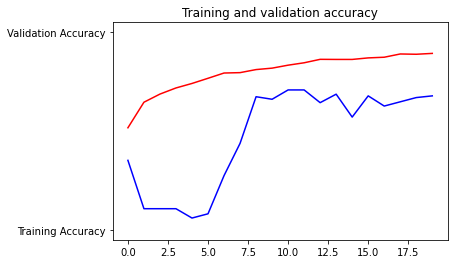

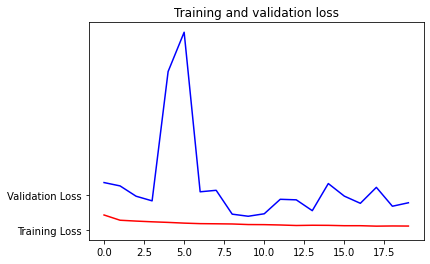

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(# YOUR CODE HERE))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")